Código, modelos y este notebook disponibles en el repositorio: [https://github.com/d-bcarrue/zika](https://github.com/d-bcarrue/zika).

## Descripción del proyecto
Predicción de síntomas en un paciente con una cepa específica del virus Zika usando datos clínicos específicos y métodos de Machine Learning.  

- **Preprocesado de datos**
  - Buscar errores o missing values y eliminar estas filas.
  - Buscar columnas repetidas y eliminar las duplicadas.
  - Balanceo de clases.  


- **Entrenamiento de modelos**
  - Selección del tipo de modelo.
  - Búsqueda de los hiperparámetros óptimos.  


- **Resultados**
  - Curvas de aprendizaje.
  - Precisión final del modelo.
  - Guardado de modelos.

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     ParameterGrid, cross_val_score,
                                    learning_curve, ShuffleSplit)
from imblearn.over_sampling import SMOTE
import warnings
import itertools as it
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# Cargamos dataset
df = pd.read_csv(os.path.join('ds_Zika.csv'))

## Preprocesado de datos

**Comprobamos que no haya "missing values"**  
Dado que no los hay, seguimos adelante.

In [3]:
attr = []
# Iteramos los atributos del dataset
for i in df.columns:
    # Comprobamos los valores de cada atributo
    attr.append(np.all(df[i].notna()))
# Ningún atributo tiene missing values:
np.all(np.array(attr))

True

**Cálculo de matriz de similitudes**  
Dado el origen medico de las caracteristicas se emplea para medir la similitud un indice muy restrictivo, se realiza la proporcion de casos que son iguales en la misma fila. Con la intencion de buscar columnas exactamente iguales.

In [4]:
resultados = np.zeros((len(df.columns), len(df.columns)))

for i in range(len(df.columns)):
    for j in range(len(df.columns)):
            resultados[i, j] = np.mean(df.iloc[:, i] == df.iloc[:, j])

**HeatMap de similitudes**

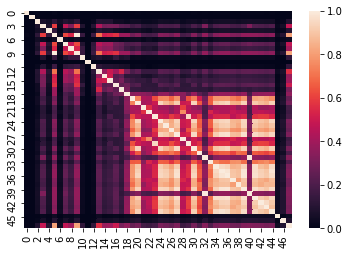

In [5]:
plt.figure()
x = sns.heatmap(resultados)
plt.show()
plt.close()

**Comprobamos que no haya variables con "near-zero variance"**

In [6]:
print(df.columns[df.std(axis=0) <= 0.001])

Index(['DSh(I)005_qr', 'DSh(I)009_qr'], dtype='object')


In [7]:
# Eliminamos esas columnas
df = df.drop(columns=[df.columns[5],df.columns[9]])
resultados = np.delete(resultados, [5,9], axis=0)
resultados = np.delete(resultados, [5,9], axis=1)

**Comprobamos que no haya variables iguales**  
Las columnas 32 y la 40 son exactamente iguales. Se quita la primera de ellas.

In [8]:
iguales = []
for i, j in it.combinations(range(len(df.columns)), 2):
    if round(resultados[i, j], 4) == 1:
        iguales.append(df.columns[i])
        print(df.columns[i], df.columns[j])

DSh(I)032_qr DSh(I)040_qr


In [9]:
# Eliminamos esas columnas
df = df.drop(columns=list(set(iguales)))

**Comprobamos que las clases no estén desbalanceadas**  
Lo están. Procedemos a balancearlas.

In [10]:
# Balanceo de clases
# Comprobamos la proporción
np.mean(df["Output"])

0.18557084417999256

**Undersampling**  
Reducimos el número de muestras negativas al número de muestras positivas, seleccionandolas de forma aleatoria.

In [11]:
df_u = df.copy()
# Número de casos positivos
nposit = len(df_u[df_u['Output'] == 1])
# Índices de casos negativos
inegat = df_u[df_u.Output == 0].index
# Cogemos aleatoriamente un número de índices negativos igual al número de casos positivos
random_indices = np.random.choice(inegat, nposit, replace=False)
# Obtenemos todos los índices positivos
iposit = df_u[df_u.Output == 1].index
# Unimos las dos listas de índices
new_indices = np.concatenate([iposit, random_indices])
df_u = df_u.loc[new_indices]
# y las desordenamos
df_u = shuffle(df_u).reset_index(drop=True)

X_u = df_u.drop('Output', axis=1)
y_u = df_u['Output']

Xdata_u = X_u.values
ydata_u = y_u.values

**Oversampling**  
Se generan muestras sinteticas positivas que siguen la misma distribución que las originales.

In [12]:
df_o = df.copy()
X_o = df_o.drop('Output', axis=1)
y_o = df_o['Output']
Xdata_o = X_o.values
ydata_o = y_o.values
Xdata_o, ydata_o = SMOTE().fit_resample(Xdata_o, ydata_o)

## Entrenamiento de Modelos - Undersampled

In [13]:
# Suprimimos warnings para legibilidad (nota: no recomendamos hacer esto)
warnings.filterwarnings("ignore")

In [14]:
# Probamos con undersampling
Xdata = Xdata_u
ydata = ydata_u

### Selección del modelo  
Se prueba con una batería de diferentes modelos de clasificación, con los parámetros por defecto.

In [15]:
# K Neighbors
knb = KNeighborsClassifier()

# LDC:
ldc = LinearDiscriminantAnalysis()

# Bayesian:
gnb = GaussianNB()

# Multilayer Perceptron
mlp = MLPClassifier()

# SVM:
svm = SVC()

# Random Forest
rndf = RandomForestClassifier()

models = [knb, ldc, gnb, mlp, svm, rndf]
model_names = ['KNeighborsClassifier', 'LinearDiscriminantAnalysis', 'GaussianNB',
               'MLPClassifier', 'SVC', 'RandomForestClassifier']
scores = []
for model in models:
    score = cross_val_score(model, Xdata, ydata, cv=10)
    scores.append((np.mean(score), np.std(score)))
x = pd.DataFrame(np.array(scores), columns=['Mean','Standard Deviation'], index=model_names)
x
# Nos quedamos con RandomForest

,Mean,Standard Deviation
KNeighborsClassifier,0.893758,0.019712
LinearDiscriminantAnalysis,0.867177,0.019101
GaussianNB,0.794571,0.016499
MLPClassifier,0.909788,0.012327
SVC,0.794571,0.016499
RandomForestClassifier,0.930343,0.012469


### Búsqueda de hiperparámetros
- n_estimators: Número de árboles
- max_depth: Profundidad máxima del árbol
- min_samples_leaf: Número mínimo de muestras requeridas en una hoja

In [16]:
# División entre training y test
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                    test_size=0.2,
                                                    stratify=ydata, random_state=1234)
# Hiperparámetros a probar
param_grid = {'n_estimators': range(1, 101, 10),
               'max_depth': range(1, 26, 5),
               'min_samples_leaf': range(1, 11, 5)}

alg = RandomForestClassifier(random_state=1234)
# Grid Search con cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1234)
grid = GridSearchCV(alg, param_grid=param_grid, cv=cv, return_train_score=True)
grid.fit(X_train, y_train)
print(grid.best_params_)
print('validation accuracy:', grid.score(X_train, y_train))
print('test accuracy:', grid.score(X_test, y_test))

{'max_depth': 21, 'min_samples_leaf': 1, 'n_estimators': 71}
validation accuracy: 0.9987468671679198
test accuracy: 0.94


**Mejores parámetros**  
La función GridSearchCV devuelve unos parámetros que tienen una gran diferencia entre el train score y el test score, por lo tanto establecemos un nuevo criterio para la selección de los mismos.

In [17]:
# Queremos que haya poca diferencia entre validación y test
c = pd.DataFrame(grid.cv_results_)
c['train_test_difference'] = c.mean_train_score - c.mean_test_score
# Diferencia máxima entre validación y test
max_diff = 0.02
# Precisión mínima en test
min_test_score = 0.90
c_sorted = c[(c.mean_test_score >= min_test_score) & (c.train_test_difference <= max_diff)][(
    ['mean_train_score', 'mean_test_score','train_test_difference'])].sort_values('mean_test_score', ascending=False)
# Ordenamos por error en test
c_sorted.head(n=10)

,mean_train_score,mean_test_score,train_test_difference
36,0.919201,0.906250,0.012951
37,0.918966,0.904375,0.014591
38,0.920533,0.902188,0.018345
39,0.921003,0.901563,0.019441
35,0.919828,0.900937,0.018890
34,0.919201,0.900000,0.019201


In [18]:
# Obtenemos los mejores hiperparámetros según nuestro criterio
i = c_sorted.first_valid_index()
max_depth = c.param_max_depth.iloc[i]
min_samples_leaf = c.param_min_samples_leaf.iloc[i]
n_estimators = c.param_n_estimators.iloc[i]
print('Max depth: {} - Min. samples leaf: {} - Num. estimators: {}'.format(max_depth, min_samples_leaf, n_estimators))

Max depth: 6 - Min. samples leaf: 6 - Num. estimators: 61


## Resultados - Undersampled

In [19]:
# Obtenemos el modelo con los hiperparámetros elegidos
alg_u = RandomForestClassifier(random_state=1234, max_depth=max_depth,
                              min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)

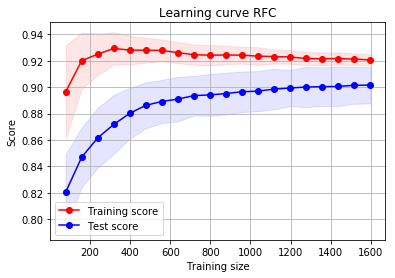

In [20]:
# Calculamos la curva de aprendizaje
cv = ShuffleSplit(n_splits=100, test_size=0.2)
train_sizes = np.linspace(0.05, 1, num=20)
train_sizes, train_scores, test_scores = learning_curve(
        alg_u, Xdata, ydata, cv=cv, train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot
plt.figure()
plt.title('Learning curve RFC')
plt.xlabel('Training size')
plt.ylabel('Score')
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='b')
plt.plot(train_sizes, train_scores_mean, 'ro-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'bo-', label='Test score')
plt.legend(loc='best')
plt.show()
plt.close()

In [21]:
# Cambiamos la división entre training y test
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                    test_size=0.3,
                                                    stratify=ydata, random_state=1234)
alg_u.fit(X_train, y_train)
print('training accuracy:', alg_u.score(X_train, y_train))
print('test accuracy:', alg_u.score(X_test, y_test))

training accuracy: 0.9255547602004295
test accuracy: 0.9031719532554258


**Mejores parámetros en función de la precisión en test**

In [22]:
# Modelo con mejores resultados
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']
n_estimators = grid.best_params_['n_estimators']
best = RandomForestClassifier(random_state=1234, max_depth=max_depth,
                              min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)

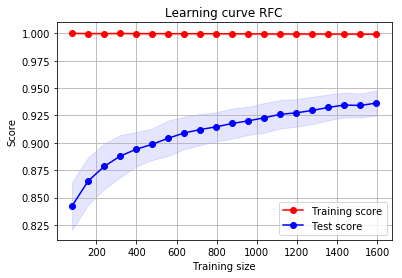

In [23]:
# Calculamos la curva de aprendizaje
cv = ShuffleSplit(n_splits=100, test_size=0.2)
train_sizes = np.linspace(0.05, 1, num=20)
train_sizes, train_scores, test_scores = learning_curve(
        best, Xdata, ydata, cv=cv, train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot
plt.figure()
plt.title('Learning curve RFC')
plt.xlabel('Training size')
plt.ylabel('Score')
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='b')
plt.plot(train_sizes, train_scores_mean, 'ro-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'bo-', label='Test score')
plt.legend(loc='best')
plt.show()
plt.close()

## Entrenamiento de modelos - Oversampled

In [24]:
# Probamos con oversampling:
Xdata = Xdata_o
ydata = ydata_o

### Selección del modelo  
Se prueba con una batería de diferentes modelos de clasificación, con los parámetros por defecto.

In [25]:
# K Neighbors
knb = KNeighborsClassifier()

# LDC:
ldc = LinearDiscriminantAnalysis()

# Bayesian:
gnb = GaussianNB()

# Multilayer Perceptron
mlp = MLPClassifier()

# SVM:
svm = SVC()

# Random Forest
rndf = RandomForestClassifier()

models = [knb, ldc, gnb, mlp, svm, rndf]
model_names = ['KNeighborsClassifier', 'LinearDiscriminantAnalysis', 'GaussianNB',
               'MLPClassifier', 'SVC', 'RandomForestClassifier']
scores = []
for model in models:
    score = cross_val_score(model, Xdata, ydata, cv=10)
    scores.append((np.mean(score), np.std(score)))
x = pd.DataFrame(np.array(scores), columns=['Mean','Standard Deviation'], index=model_names)
x
# Nos quedamos con RandomForest

,Mean,Standard Deviation
KNeighborsClassifier,0.952511,0.009092
LinearDiscriminantAnalysis,0.874658,0.008736
GaussianNB,0.789041,0.009271
MLPClassifier,0.960046,0.011427
SVC,0.861986,0.006527
RandomForestClassifier,0.972374,0.014635


### Búsqueda de hiperparámetros
- n_estimators: Número de árboles
- max_depth: Profundidad máxima del árbol
- min_samples_leaf: Número mínimo de muestras requeridas en una hoja

In [26]:
# División entre training y test
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata,
                                                    test_size=0.2,
                                                    stratify=ydata, random_state=1234)
# Hiperparámetros a probar
param_grid = {'n_estimators': range(1, 101, 10),
               'max_depth': range(1, 26, 5),
               'min_samples_leaf': range(1, 11, 5)}

alg = RandomForestClassifier(random_state=1234)
# Grid Search con cross validation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=1234)
grid = GridSearchCV(alg, param_grid=param_grid, cv=cv, return_train_score=True)
grid.fit(X_train, y_train)
print(grid.best_params_)
print('validation accuracy:', grid.score(X_train, y_train))
print('test accuracy:', grid.score(X_test, y_test))

{'max_depth': 16, 'min_samples_leaf': 1, 'n_estimators': 31}
validation accuracy: 0.9972888127853882
test accuracy: 0.9788812785388128


**Mejores parámetros**  
La función GridSearchCV devuelve unos parámetros que tienen una gran diferencia entre el train score y el test score, por lo tanto establecemos un nuevo criterio para la selección de los mismos.

In [27]:
# Queremos que haya poca diferencia entre validación y test
c = pd.DataFrame(grid.cv_results_)
c['train_test_difference'] = c.mean_train_score - c.mean_test_score
# Diferencia máxima entre validación y test
max_diff = 0.02
# Precisión mínima en test
min_test_score = 0.90
c_sorted = c[(c.mean_test_score >= min_test_score) & (c.train_test_difference <= max_diff)][(
    ['mean_train_score', 'mean_test_score','train_test_difference'])].sort_values('mean_test_score', ascending=False)
# Ordenamos por error en test
c_sorted.head(n=10)

,mean_train_score,mean_test_score,train_test_difference
48,0.990100,0.971683,0.018417
47,0.989957,0.971612,0.018345
49,0.990153,0.971541,0.018613
45,0.990189,0.971469,0.018720
46,0.989993,0.971327,0.018666
43,0.989351,0.970827,0.018523
44,0.989672,0.970471,0.019201
42,0.988637,0.969330,0.019308
41,0.986158,0.967903,0.018255
98,0.976525,0.965050,0.011475


In [28]:
# Obtenemos los mejores hiperparámetros según nuestro criterio
i = c_sorted.first_valid_index()
max_depth = c.param_max_depth.iloc[i]
min_samples_leaf = c.param_min_samples_leaf.iloc[i]
n_estimators = c.param_n_estimators.iloc[i]
print('Max depth: {} - Min. samples leaf: {} - Num. estimators: {}'.format(max_depth, min_samples_leaf, n_estimators))

Max depth: 11 - Min. samples leaf: 1 - Num. estimators: 81


## Resultados - Oversampled

In [29]:
# Obtenemos el modelo con los hiperparámetros elegidos
alg_o = RandomForestClassifier(random_state=1234, max_depth=max_depth,
                              min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)

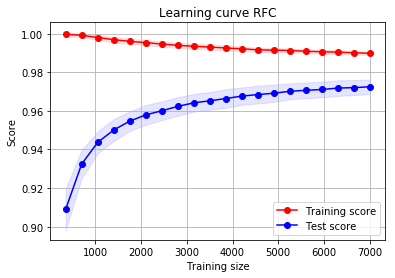

In [30]:
# Calculamos la curva de aprendizaje
cv = ShuffleSplit(n_splits=100, test_size=0.2)
train_sizes = np.linspace(0.05, 1, num=20)
train_sizes, train_scores, test_scores = learning_curve(
        alg_o, Xdata, ydata, cv=cv, train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot
plt.figure()
plt.title('Learning curve RFC')
plt.xlabel('Training size')
plt.ylabel('Score')
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='b')
plt.plot(train_sizes, train_scores_mean, 'ro-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'bo-', label='Test score')
plt.legend(loc='best')
plt.show()
plt.close()

**Mejores parámetros en función de la precisión en test**

In [31]:
# Modelo con mejores resultados
max_depth = grid.best_params_['max_depth']
min_samples_leaf = grid.best_params_['min_samples_leaf']
n_estimators = grid.best_params_['n_estimators']
best = RandomForestClassifier(random_state=1234, max_depth=max_depth,
                              min_samples_leaf=min_samples_leaf, n_estimators=n_estimators)

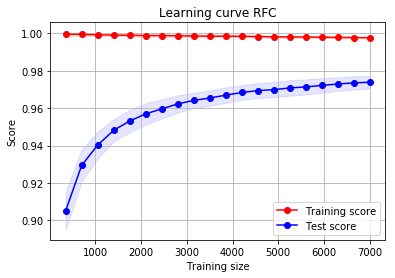

In [32]:
# Calculamos la curva de aprendizaje
cv = ShuffleSplit(n_splits=100, test_size=0.2)
train_sizes = np.linspace(0.05, 1, num=20)
train_sizes, train_scores, test_scores = learning_curve(
        best, Xdata, ydata, cv=cv, train_sizes=train_sizes)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# plot
plt.figure()
plt.title('Learning curve RFC')
plt.xlabel('Training size')
plt.ylabel('Score')
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='b')
plt.plot(train_sizes, train_scores_mean, 'ro-', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'bo-', label='Test score')
plt.legend(loc='best')
plt.show()
plt.close()

In [33]:
# Reactivamos warnings
warnings.filterwarnings("default")

## Persistencia

In [34]:
with open('RForest_Zika_oversampled.bin','wb') as file:
    pickle.dump(alg_o, file)
with open('RForest_Zika_undersampled.bin','wb') as file:
    pickle.dump(alg_u, file)

## FIN